<a href="https://colab.research.google.com/github/HarshalPawar88/Evaluation-Projects/blob/main/Census_Income_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Problem Statement:**


### This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

### Description of fnlwgt (final weight)
### The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

### A single cell estimate of the population 16+ for each state.

### Controls for Hispanic Origin by age and sex.

### Controls by Race, age and sex.

### We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score, f1_score,roc_auc_score
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv')

In [3]:
df.shape

(32560, 15)

In [4]:
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Observations:
### There are no missing values.

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(32536, 15)

## Observations:
## 1. There were few duplicate observations which I successfully dropped.

In [8]:
df['Income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [9]:
df.nunique()

Age                  73
Workclass             9
Fnlwgt            21647
Education            16
Education_num        16
Marital_status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_gain        119
Capital_loss         92
Hours_per_week       94
Native_country       42
Income                2
dtype: int64

In [10]:
df['Income'].value_counts()

 <=50K    24697
 >50K      7839
Name: Income, dtype: int64

In [11]:
7841/(24719+7841)

0.24081695331695332

## Observations:
## 1. It is clear that this is a highly imbalanced dataset with the minority class occupying just 24% of the observations.

In [12]:
list_=[x for x in df.columns if df[x].nunique()>42]

In [13]:
len(list_)

5

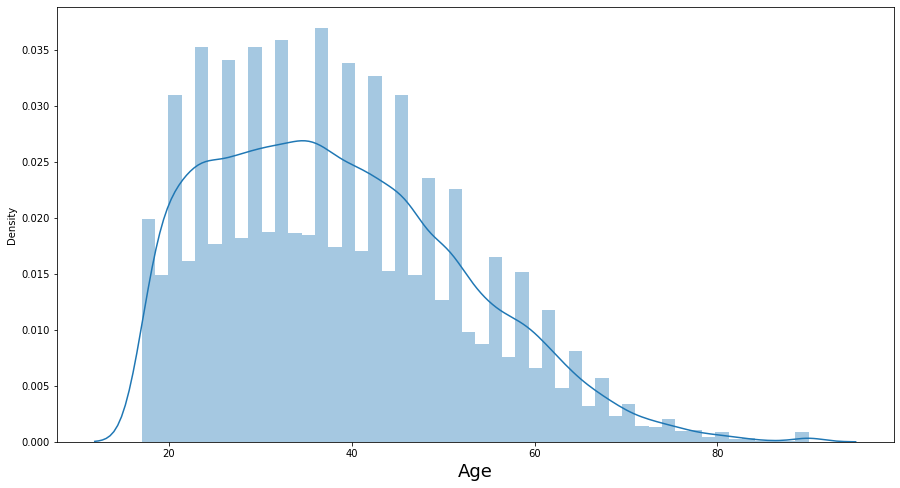

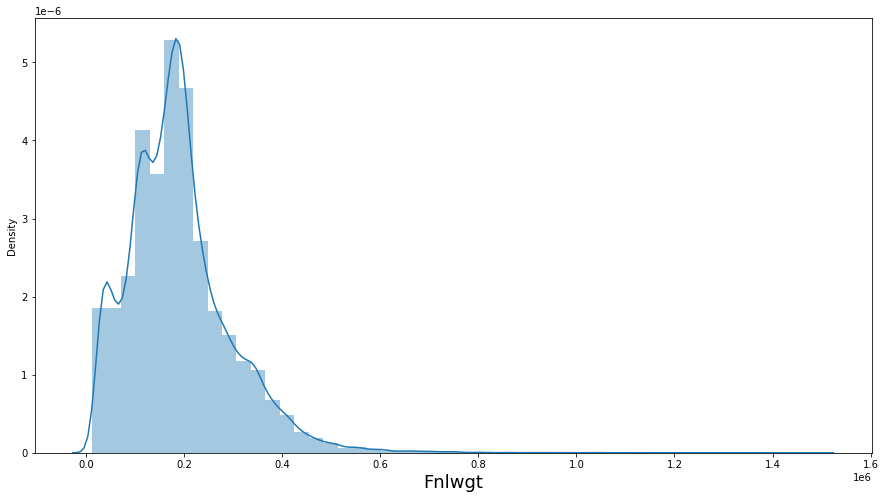

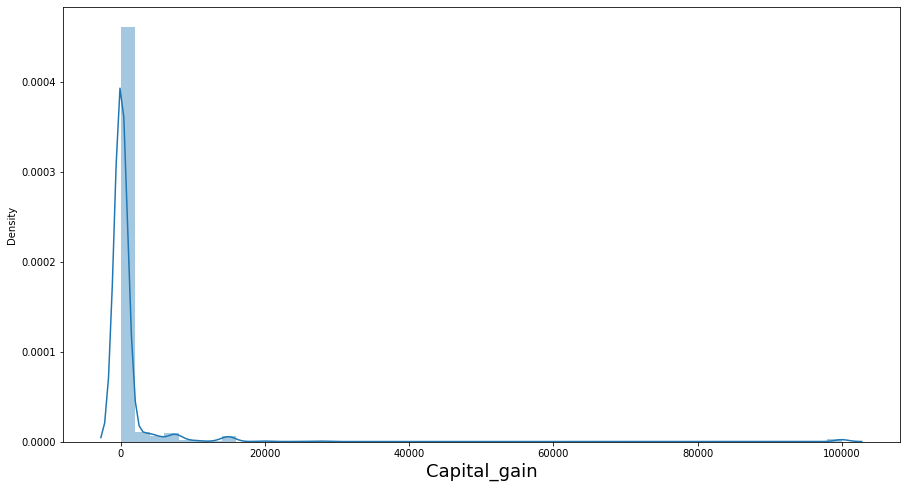

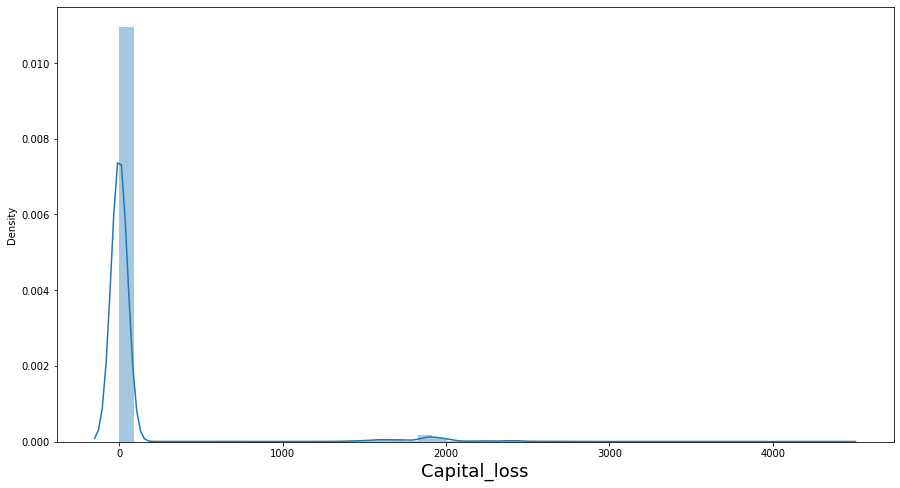

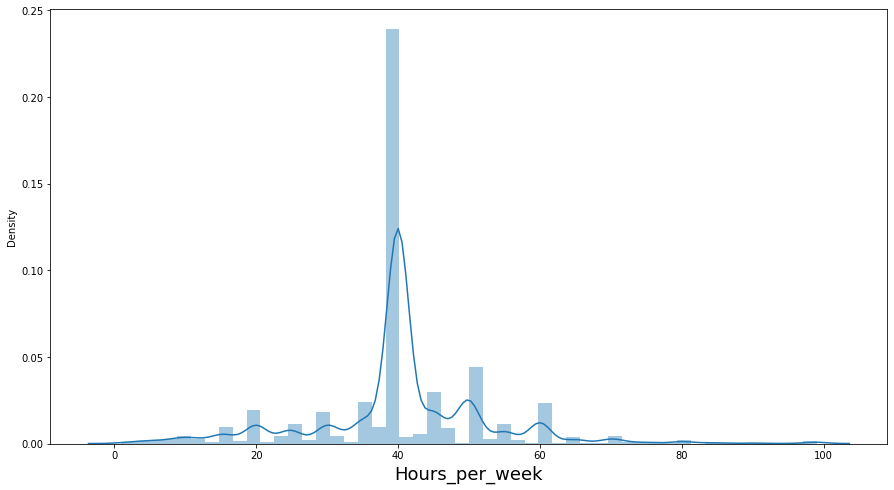

In [14]:
for i in list_:
  plt.figure(figsize=(15,8))
  sns.distplot(df[i])
  plt.xlabel(i,fontsize=18)
  plt.show()

### As the dataset is highly imbalanced, removing outliers might prove to be a way of loosing important information. Because the values that we cap might be corresponding to those minority classes.

In [15]:
pt=PowerTransformer(standardize=False)
pt.fit(df[list_])
df[list_]=pt.transform(df[list_])

In [16]:
df['Hours_per_week'].sort_values()

1261      1.000146
22959     1.000146
19749     1.000146
8446      1.000146
23535     1.000146
           ...    
5431     99.136367
30991    99.136367
21146    99.136367
13579    99.136367
12208    99.136367
Name: Hours_per_week, Length: 32536, dtype: float64

In [17]:
df[list_].corr()

,Age,Fnlwgt,Capital_gain,Capital_loss,Hours_per_week
Age,1.000000,-0.068201,0.123598,0.056114,0.127840
Fnlwgt,-0.068201,1.000000,-0.002925,-0.006277,-0.022326
Capital_gain,0.123598,-0.002925,1.000000,-0.066720,0.074999
Capital_loss,0.056114,-0.006277,-0.066720,1.000000,0.050409
Hours_per_week,0.127840,-0.022326,0.074999,0.050409,1.000000


## Observations:
## 1.There is no multicollinearity within any features.

### Checking if the two classes are visually separable.


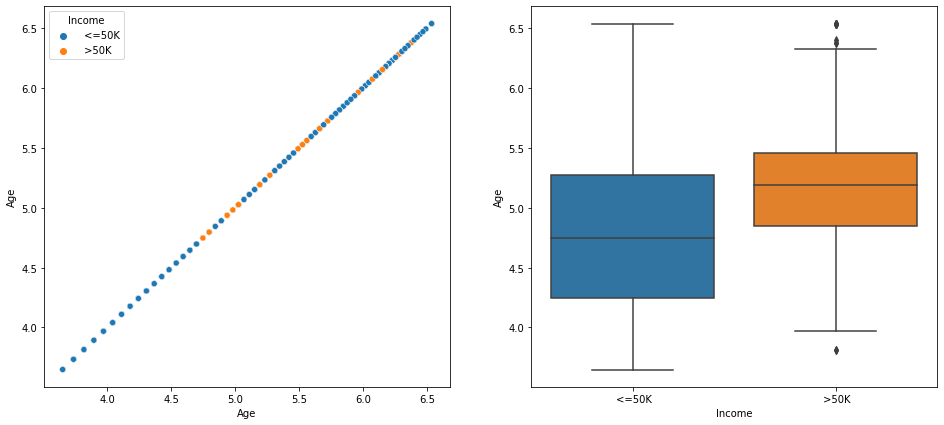

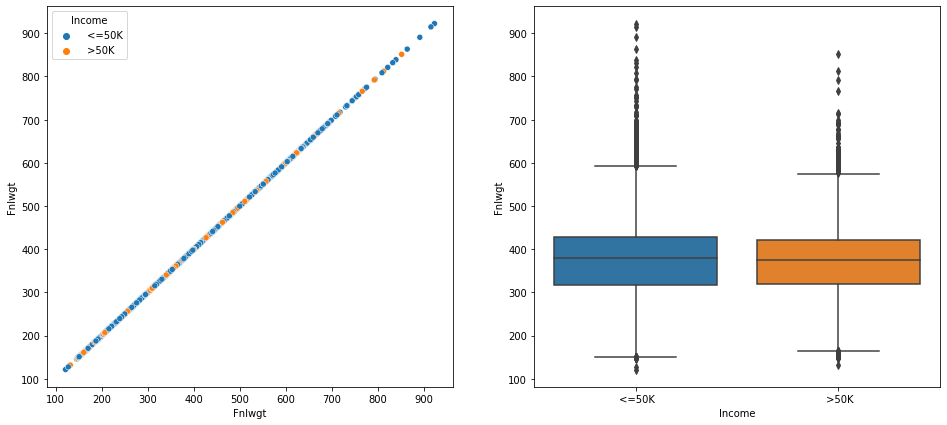

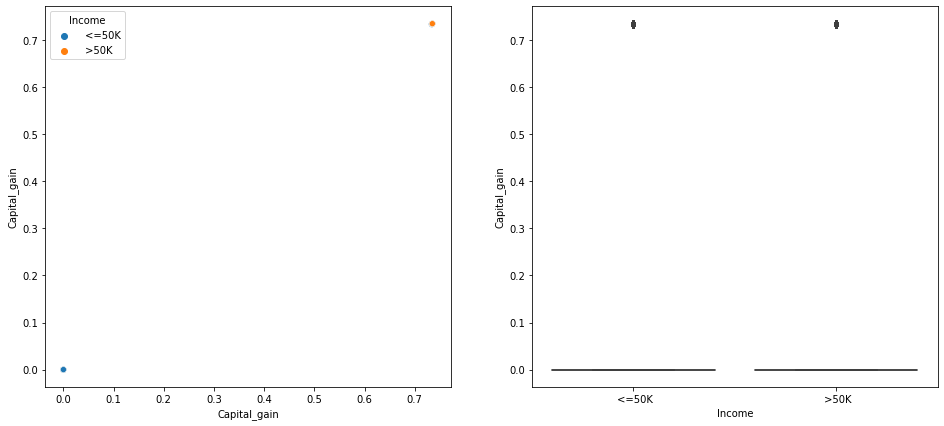

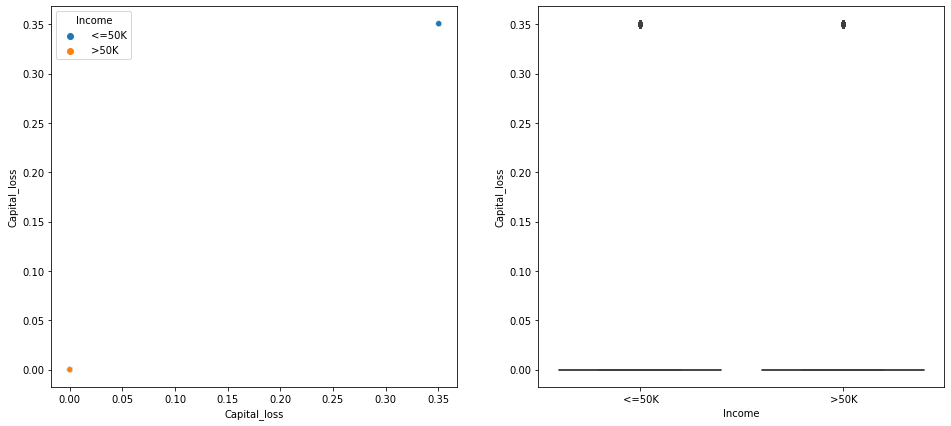

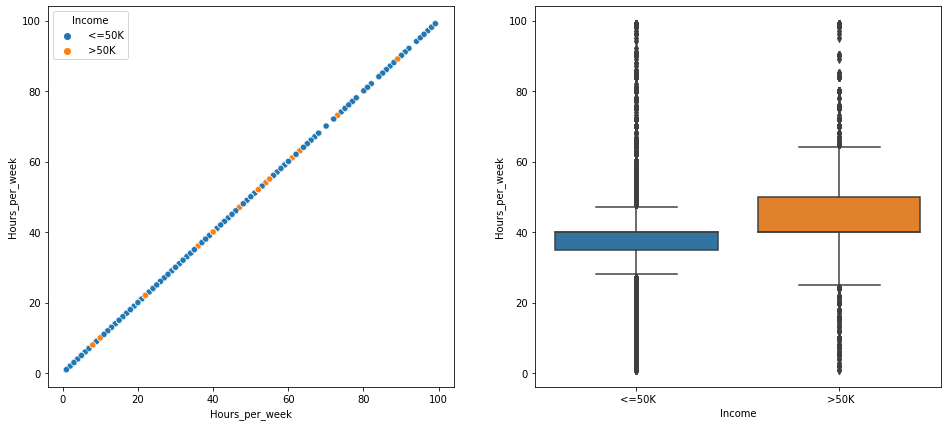

In [18]:
for i in list_:
  fig,axes=plt.subplots(1,2, figsize=(16,7))
  sns.scatterplot(df[i],df[i], hue=df['Income'],ax=axes[0])
  sns.boxplot(x=df['Income'],y=df[i],ax=axes[1])
  plt.show()

## Observations:
## 1. Columns like capital loss and capital gain show that the income is greater than 50k when the value of those features increase.
## 2. More the age, higher are the chances of the income being more than 50k.

In [19]:
categorical_cols=[x for x in df.columns if x not in list_]

In [20]:
df[categorical_cols].head()

,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
0,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
1,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
2,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
3,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
4,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,<=50K


In [21]:
for i in categorical_cols:
  print(df[i].value_counts())
  

 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
 HS-grad         10494
 Some-college     7282
 Bachelors        5352
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: Education, dtype: int64
9     10494
10     7282
13     5352
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: Education_num, dtype: int64
 Married-civ-spouse       14970
 Never-married            10666
 Divorced                  4441
 Separa

In [22]:
df.drop(columns='Native_country',inplace=True)

## Observations:
## 1. The 'Workclass', 'Native Counntry' and 'Occupation'
## column has a '?' value. I shall  replace it with another string.


In [23]:
df['Workclass']=df['Workclass'].apply(lambda x:'Other' if x in [' ?'] else x)
#df['Native_country']=df['Native_country'].apply(lambda x:'Other' if x in [' ?'] else x)
df['Occupation']=df['Occupation'].apply(lambda x:'Other' if x in [' ?'] else x)

In [24]:
df['Education']=df['Education'].apply(lambda x:'School' if x in [' 11th',' 10th',' 7th-8th',' 9th',' 12th',' 5th-6th',' 1st-4th'] else x)

In [25]:
df['Education'].unique()

array([' Bachelors', ' HS-grad', 'School', ' Masters', ' Some-college',
       ' Assoc-acdm', ' Assoc-voc', ' Doctorate', ' Prof-school',
       ' Preschool'], dtype=object)

In [26]:
categorical_cols.remove('Native_country')

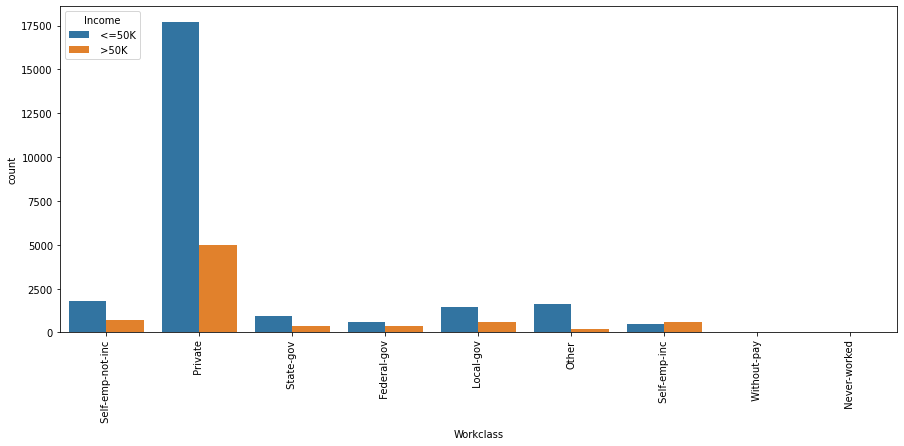

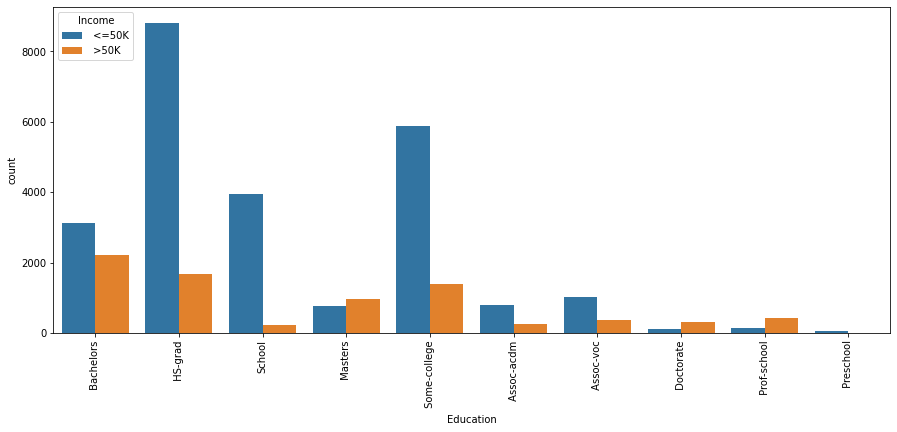

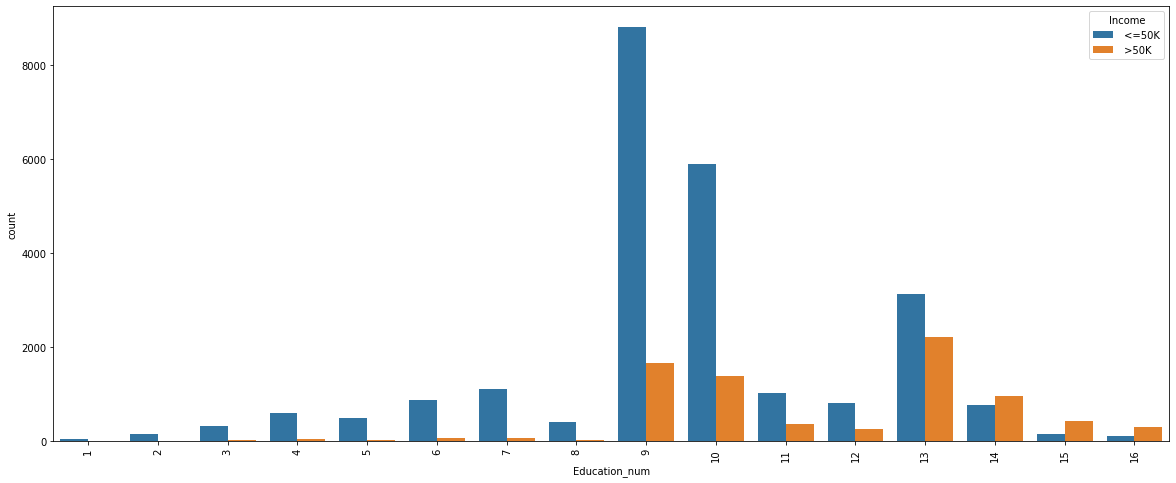

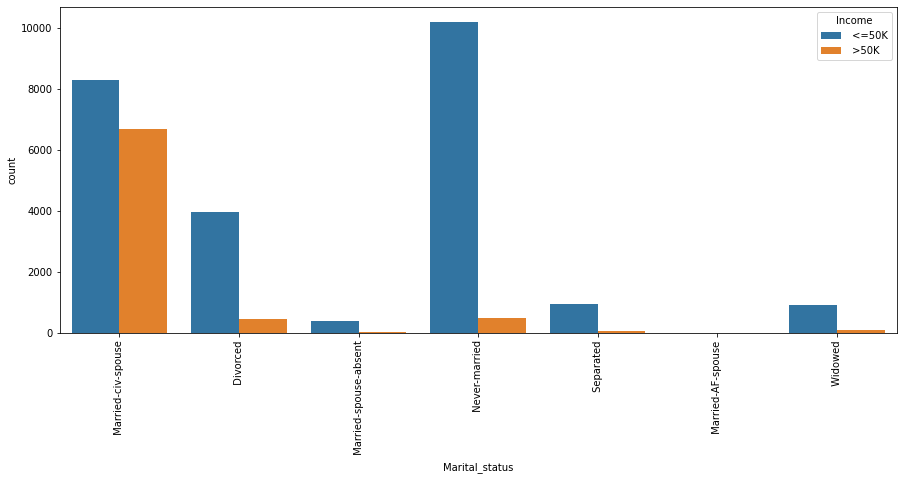

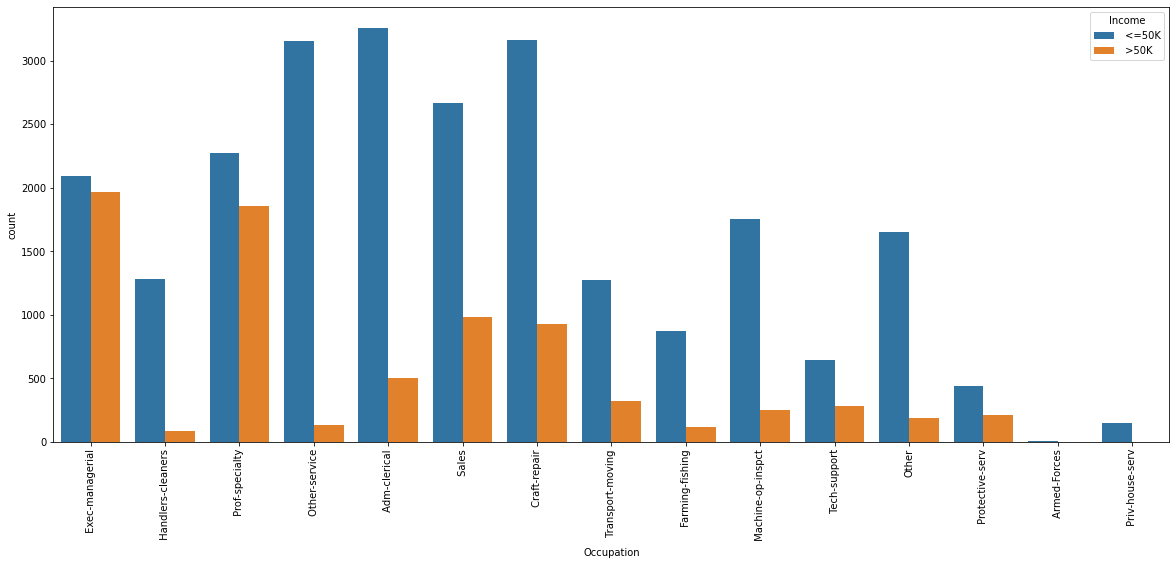

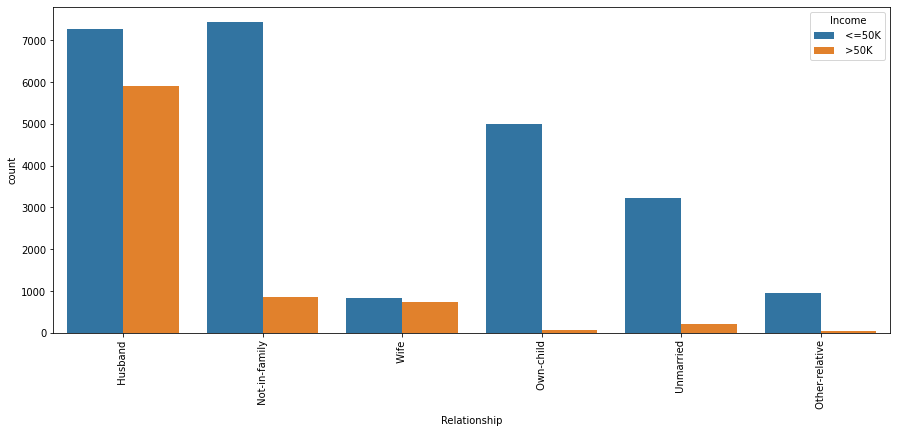

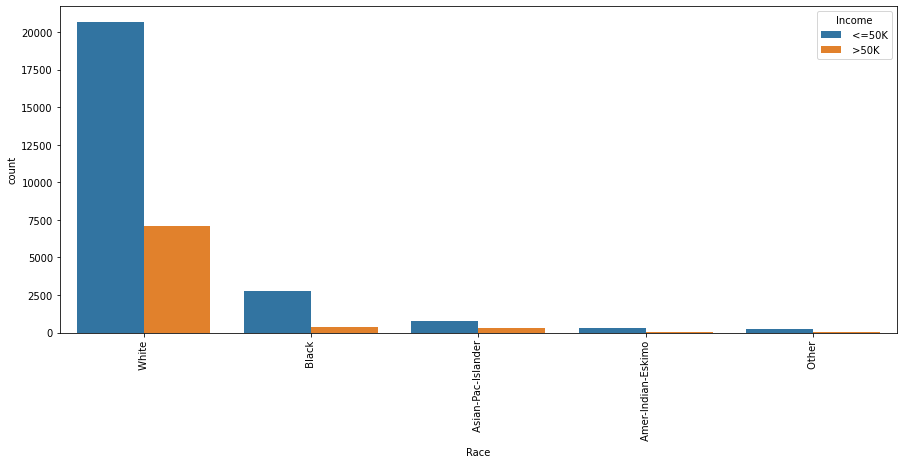

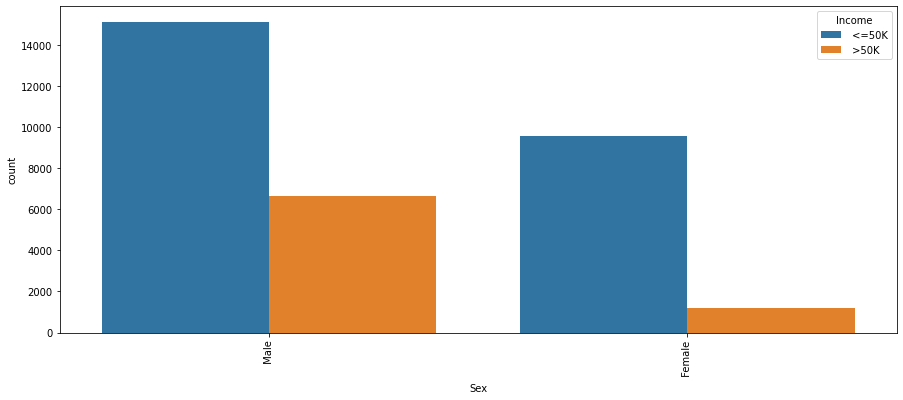

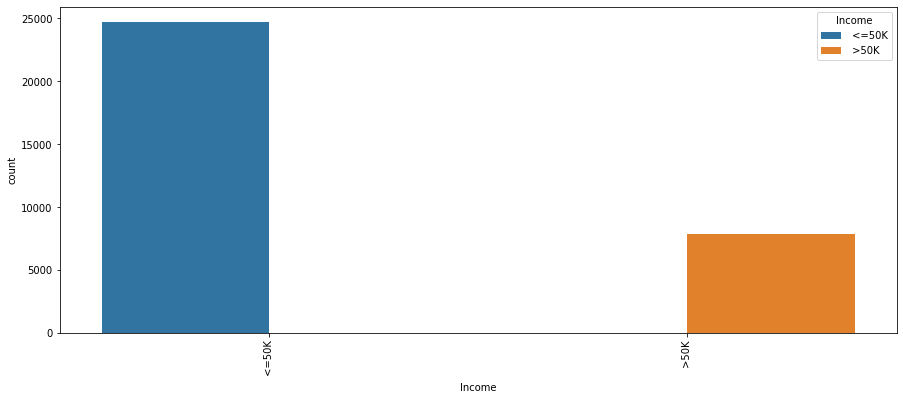

In [27]:
for i in categorical_cols:
  if df[i].nunique()>10:
    plt.figure(figsize=(20,8))
    sns.countplot(df[i],hue=df['Income'])
    plt.xticks(rotation=90)
    plt.show()
  else:
    plt.figure(figsize=(15,6))
    sns.countplot(df[i],hue=df['Income'])
    plt.xticks(rotation=90)
    plt.show()

In [28]:
df=pd.get_dummies(df,columns=['Workclass','Education','Marital_status','Occupation','Relationship','Race','Sex'],drop_first=True )

In [29]:
df.head()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week,Income,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Workclass_Other,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Education_School,Marital_status_ Married-AF-spouse,Marital_status_ Married-civ-spouse,Marital_status_ Married-spouse-absent,Marital_status_ Never-married,Marital_status_ Separated,Marital_status_ Widowed,Occupation_ Armed-Forces,Occupation_ Craft-repair,Occupation_ Exec-managerial,Occupation_ Farming-fishing,Occupation_ Handlers-cleaners,Occupation_ Machine-op-inspct,Occupation_ Other-service,Occupation_ Priv-house-serv,Occupation_ Prof-specialty,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Occupation_Other,Relationship_ Not-in-family,Relationship_ Other-relative,Relationship_ Own-child,Relationship_ Unmarried,Relationship_ Wife,Race_ Asian-Pac-Islander,Race_ Black,Race_ Other,Race_ White,Sex_ Male
0,5.421001,273.889940,13,-0.0,-0.0,13.009030,<=50K,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,4.936802,409.325561,9,-0.0,-0.0,40.042337,<=50K,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
2,5.526805,424.226307,7,-0.0,-0.0,40.042337,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,4.425012,494.984991,13,-0.0,-0.0,40.042337,<=50K,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,4.890981,460.126008,14,-0.0,-0.0,40.042337,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [30]:
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
df['Income']= label_encoder.fit_transform(df['Income'])


In [31]:
df.head()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week,Income,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Workclass_Other,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Education_School,Marital_status_ Married-AF-spouse,Marital_status_ Married-civ-spouse,Marital_status_ Married-spouse-absent,Marital_status_ Never-married,Marital_status_ Separated,Marital_status_ Widowed,Occupation_ Armed-Forces,Occupation_ Craft-repair,Occupation_ Exec-managerial,Occupation_ Farming-fishing,Occupation_ Handlers-cleaners,Occupation_ Machine-op-inspct,Occupation_ Other-service,Occupation_ Priv-house-serv,Occupation_ Prof-specialty,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Occupation_Other,Relationship_ Not-in-family,Relationship_ Other-relative,Relationship_ Own-child,Relationship_ Unmarried,Relationship_ Wife,Race_ Asian-Pac-Islander,Race_ Black,Race_ Other,Race_ White,Sex_ Male
0,5.421001,273.889940,13,-0.0,-0.0,13.009030,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,4.936802,409.325561,9,-0.0,-0.0,40.042337,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
2,5.526805,424.226307,7,-0.0,-0.0,40.042337,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,4.425012,494.984991,13,-0.0,-0.0,40.042337,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,4.890981,460.126008,14,-0.0,-0.0,40.042337,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [32]:
X=df.drop(columns='Income')
y=df['Income']

In [33]:
X.shape

(32536, 53)

## **Feature Selection**

### **1. Using permutation Feature Importance**

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y)

In [35]:
rf=RandomForestClassifier(n_estimators=100,class_weight='balanced')
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
from sklearn.inspection import permutation_importance

In [37]:
perm_importance = permutation_importance(rf, X_test, y_test)

In [38]:
perm_importance.importances_mean.sum()

0.12380132776001881

In [39]:
feature_imp_1=pd.DataFrame(zip(X.columns,perm_importance.importances_mean), columns=['columns','p_importance']).sort_values('p_importance',ascending=False)

In [40]:
feature_imp_1.reset_index(drop=True,inplace=True)

In [41]:
feature_imp_1['p_importance'][0:20].sum()

0.12908777969018914

In [42]:
permut_cols=feature_imp_1['columns'][0:20]

### **2. Using Lasso**

In [43]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y,random_state=15)
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
lr=LogisticRegression(class_weight='balanced',penalty='l1', solver='liblinear',C=0.01)
lr.fit(X_train,y_train)
y_train_pred=lr.predict(X_train)
y_test_pred=lr.predict(X_test)

In [44]:
lr.coef_

array([[ 0.66326965,  0.        ,  0.        ,  1.34898873,  0.65526734,
         0.20280796,  0.        ,  0.        ,  0.        ,  0.06582189,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.04487977,  0.        , -0.87377629,  0.05382379,  0.        ,
         0.        , -0.42492042, -1.53534972,  0.        ,  1.73137138,
         0.        , -0.53932429,  0.        ,  0.        ,  0.        ,
         0.        ,  0.78860051,  0.        ,  0.        ,  0.        ,
        -0.46032802,  0.        ,  0.614888  ,  0.        ,  0.10273156,
         0.        ,  0.        , -0.02407786,  0.        ,  0.        ,
        -0.67273605, -0.07860786,  0.01730954,  0.        ,  0.        ,
         0.        ,  0.        ,  0.15259605]])

In [45]:
lasso_columns=pd.DataFrame(zip(X.columns,lr.coef_.reshape(-1,1)),columns=['columns','coeff']).sort_values('coeff')

In [46]:
len(lasso_columns[lasso_columns['coeff']==0])

32

In [47]:
lasso_cols=list(lasso_columns[lasso_columns['coeff']!=0]['columns'])

## **1. Logistic Regression**

### Selecting the best random state.
## We will use the class_weight as 'balanced' because of the dataset being highly imbalanced.

In [48]:
X_perm=df[permut_cols]
X_lasso=df[lasso_cols]

### **a) With Permutation Feature Selection**

In [ ]:
f1_=0
for i in range(0,100): 
  X_train,X_test,y_train,y_test=train_test_split(X_perm,y,test_size=0.25,stratify=y,random_state=i)
  scaler=MinMaxScaler()
  scaler.fit(X_train)
  X_train=scaler.transform(X_train)
  X_test=scaler.transform(X_test)
  lr=LogisticRegression(class_weight='balanced')
  lr.fit(X_train,y_train)
  y_train_pred=lr.predict(X_train)
  y_test_pred=lr.predict(X_test)
  score=f1_score(y_test,y_test_pred)
  if f1_<score:
    f1_=score
    random=i
  

In [ ]:
print(random, f1_)

81 0.6754778365189101


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_perm,y,test_size=0.25,stratify=y,random_state=81)
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)
y_train_pred=lr.predict(X_train)
y_test_pred=lr.predict(X_test)

In [ ]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85     18523
           1       0.55      0.84      0.66      5879

    accuracy                           0.79     24402
   macro avg       0.74      0.81      0.76     24402
weighted avg       0.85      0.79      0.81     24402



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      6174
           1       0.56      0.85      0.68      1960

    accuracy                           0.80      8134
   macro avg       0.75      0.82      0.77      8134
weighted avg       0.85      0.80      0.82      8134



In [ ]:
f1_score(y_test,y_test_pred)

0.6754778365189101

### **b)Using Lasso Feature Selection**

In [ ]:
f1_=0
for i in range(0,100): 
  X_train,X_test,y_train,y_test=train_test_split(X_lasso,y,test_size=0.25,stratify=y,random_state=i)
  scaler=MinMaxScaler()
  scaler.fit(X_train)
  X_train=scaler.transform(X_train)
  X_test=scaler.transform(X_test)
  lr=LogisticRegression(class_weight='balanced')
  lr.fit(X_train,y_train)
  y_train_pred=lr.predict(X_train)
  y_test_pred=lr.predict(X_test)
  score=f1_score(y_test,y_test_pred)
  if f1_<score:
    f1_=score
    random=i
  

In [ ]:
print(random, f1_)

36 0.678271554372312


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_lasso,y,test_size=0.25,stratify=y,random_state=36)
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)
y_train_pred=lr.predict(X_train)
y_test_pred=lr.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_test_pred)

array([[4907, 1267],
       [ 304, 1656]])

In [ ]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85     18523
           1       0.55      0.84      0.66      5879

    accuracy                           0.80     24402
   macro avg       0.74      0.81      0.76     24402
weighted avg       0.84      0.80      0.81     24402



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      6174
           1       0.57      0.84      0.68      1960

    accuracy                           0.81      8134
   macro avg       0.75      0.82      0.77      8134
weighted avg       0.85      0.81      0.82      8134



In [ ]:
f1_score(y_test,y_test_pred)

0.678271554372312

# **2. Decision Tree**

### **a) With Permutation Feature Selection**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_perm,y,test_size=0.30,stratify=y,random_state=7)

## Decision Trees are  not sensitive to the range of the feature. Hence, they do not require any scaling.

In [ ]:
dt=DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_train_pred=dt.predict(X_train)
y_test_pred=dt.predict(X_test)

In [ ]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17288
           1       1.00      1.00      1.00      5487

    accuracy                           1.00     22775
   macro avg       1.00      1.00      1.00     22775
weighted avg       1.00      1.00      1.00     22775



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      7409
           1       0.59      0.60      0.59      2352

    accuracy                           0.80      9761
   macro avg       0.73      0.73      0.73      9761
weighted avg       0.80      0.80      0.80      9761



In [ ]:
dt_1=DecisionTreeClassifier(class_weight='balanced')
cv = StratifiedKFold(n_splits=5)
param={'max_depth':[10,12,14,16],'max_features':[20,25,30,8,10,15]}
dt_s_gscv=GridSearchCV(dt_1,param_grid=param,cv=cv)
dt_s_gscv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'

In [ ]:
y_train_pred=dt_s_gscv.predict(X_train)
y_test_pred=dt_s_gscv.predict(X_test)

In [ ]:
dt_s_gscv.best_params_

{'max_depth': 10, 'max_features': 20}

In [ ]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87     17288
           1       0.59      0.89      0.71      5487

    accuracy                           0.82     22775
   macro avg       0.77      0.85      0.79     22775
weighted avg       0.87      0.82      0.83     22775



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7409
           1       0.56      0.84      0.67      2352

    accuracy                           0.80      9761
   macro avg       0.75      0.81      0.76      9761
weighted avg       0.85      0.80      0.81      9761



In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_lasso,y,test_size=0.30,stratify=y,random_state=65)

In [ ]:
dt=DecisionTreeClassifier(class_weight='balanced',max_depth=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_train_pred=dt.predict(X_train)
y_test_pred=dt.predict(X_test)

In [ ]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     17288
           1       0.62      0.94      0.75      5487

    accuracy                           0.85     22775
   macro avg       0.80      0.88      0.82     22775
weighted avg       0.89      0.85      0.86     22775



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      7409
           1       0.55      0.82      0.66      2352

    accuracy                           0.80      9761
   macro avg       0.74      0.81      0.76      9761
weighted avg       0.84      0.80      0.81      9761



In [ ]:
dt_1=DecisionTreeClassifier(class_weight='balanced')
cv = StratifiedKFold(n_splits=5)
param={'max_depth':[10,15,8,17,21,19],'max_features':[20,10,12,17,8],'ccp_alpha':[1e-08,1e-07,1e-06]}
dt_s_gscv=GridSearchCV(dt_1,param_grid=param,cv=cv)
dt_s_gscv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'

In [ ]:
y_train_pred=dt_s_gscv.predict(X_train)
y_test_pred=dt_s_gscv.predict(X_test)

In [ ]:
dt_s_gscv.best_params_

{'ccp_alpha': 1e-07, 'max_depth': 19, 'max_features': 8}

In [ ]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     17288
           1       0.66      0.95      0.78      5487

    accuracy                           0.87     22775
   macro avg       0.82      0.90      0.84     22775
weighted avg       0.90      0.87      0.88     22775



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7409
           1       0.56      0.78      0.66      2352

    accuracy                           0.80      9761
   macro avg       0.74      0.80      0.76      9761
weighted avg       0.84      0.80      0.81      9761



# **3. Support Vector Machine**

In [51]:
!pip install scikit-optimize

     |████████████████████████████████| 101 kB 4.7 MB/s 


In [52]:
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X_perm,y,test_size=0.30,stratify=y,random_state=7)

In [ ]:
params = dict()
params['C'] = (1e-3,1)
params['gamma'] = (1e-3,1)
params['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
# define the search
search = BayesSearchCV(estimator=svm.SVC(class_weight='balanced'), search_spaces=params, n_jobs=-1, cv=cv)
# perform the search
search.fit(X_train, y_train)
# report the best result
print(search.best_score_)
print(search.best_params_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from scipy.stats import randint


In [ ]:
# Creating the hyperparameter grid 
param_dist = {"kernel": ['rbf','linear','poly'],
              'C':[1e-08,1e02],
              'gamma':[1e-05,1e02]}
sv_1=svm.SVC(class_weight='balanced')
sv_gscv = RandomizedSearchCV(sv_1, param_dist, cv = 5)
sv_gscv.fit(X_train,y_train)


In [ ]:
y_train_pred=sv_gscv.predict(X_train)
y_test_pred=sv_gscv.predict(X_test)

In [ ]:
sv_gscv.best_params_

In [ ]:
print(classification_report(y_train,y_train_pred))

In [ ]:
print(classification_report(y_test,y_test_pred))